### References: 
- https://www.cs.cmu.edu/~rsalakhu/papers/oneshot1.pdf
- http://vis-www.cs.umass.edu/Lfw/#download 

## 01_preprocessing

### 1.1 Import dependencies

In [1]:
# important standard dependencies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [5]:
# Important tensorflow dependencies - functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf


### 1.2 Set GPU Growth

In [4]:
# Avoid OOM errors by settings GPU Memeory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [5]:
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### 1.3 Create Folder structure

In [6]:
# setup paths
POS_PATH = os.path.join('data', 'posetive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [7]:
# # Make the directories
# !rm -r data
# os.makedirs(POS_PATH)
# os.makedirs(NEG_PATH)
# os.makedirs(ANC_PATH)

In [8]:
POS_PATH

'data/posetive'

# 02_Collect Posetives and Anchors

### 2.1 Untar Labelled Faces in the wild Dataset

In [6]:
# http://vis-www.cs.umass.edu/Lfw/  

In [7]:
# uncompress Tar GZ Labelled Faces in the wild Dataset
!tar -xf lfw.tgz

/bin/bash: /home/hadush/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/cv2/../../../../lib/libtinfo.so.6: no version information available (required by /bin/bash)
tar: lfw.tgz: Cannot open: No such file or directory
tar: Error is not recoverable: exiting now


In [9]:
# # Move lfw images to the following repository: data/negative
# for directory in os.listdir('lfw'):
#     for file in os.listdir(os.path.join('lfw',directory)):
#         EX_PATH = os.path.join('lfw', directory, file)
#         NEW_PATH = os.path.join(NEG_PATH, file)
#         os.replace(EX_PATH, NEW_PATH)

### 2.2 Collect Positive and Anchor Classes

In [10]:
# Import uuid library to generate unique names
import uuid

In [11]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()

    # Cut-down the frame to 250, 250 pixels size
    frame = frame[100:100+250, 200:200+250, :]

    # Collect anchors dataset
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # Create the unique file path
        imgname= os.path.join( ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname, frame)
        
    # Collect positives dataset
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # Create the unique file path
        imgname= os.path.join( POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname, frame)
    
    cv2.imshow("Image Collection Frame", frame)

    # breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
# Release the webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows()

[ WARN:0@59.322] global /croot/opencv-suite_1676452025216/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created


In [11]:
cap.release()
# Close the image show frame
cv2.destroyAllWindows()

# 03  Load and Preprocess Images

### 3.1 Get Images Directories

In [13]:
anchor = tf.data.Dataset.list_files(ANC_PATH + '/*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH + '/*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH + '/*.jpg').take(300)

In [14]:
dir_test = anchor.as_numpy_iterator()
dir_test.next()

b'data/anchor/b455a902-18c3-11ef-9a82-709cd1155f4a.jpg'

### 3.2 Preprocessing - scale and resize

In [15]:
def preprocess(file_path):
    # Read In image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image
    img = tf.io.decode_jpeg(byte_img)
    # Preprocessing step - resize the image to a 100 x 100 x 3
    img = tf.image.resize(img, (100,100))
    # scaling image between 0 and 1
    img = img/255.0
    
    return img

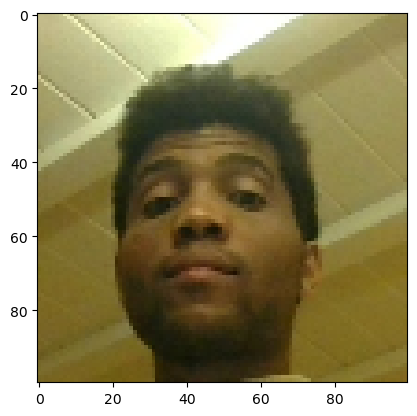

In [17]:
img = preprocess(dir_test.next())
plt.imshow(img)

### 3.3 Create labelled dataset

In [18]:
## tf.data.Dataset.from_tensor_slices is used here to provide a wr
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [19]:
sample = data.as_numpy_iterator()
sample.next()

(b'data/anchor/f4709592-18c3-11ef-9a82-709cd1155f4a.jpg',
 b'data/posetive/e93c6018-18c1-11ef-9a82-709cd1155f4a.jpg',
 1.0)

### 3.4 Build train and test partitions

In [20]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img),preprocess(validation_img), label)


In [21]:
res = preprocess_twin(*sample.next())

In [22]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [23]:
data

<ShuffleDataset shapes: ((100, 100, None), (100, 100, None), ()), types: (tf.float32, tf.float32, tf.float32)>

In [24]:
# Training partition
train_data = data.take(round(len(data) * 0.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [25]:
# print(train_data)
# train_samples = train_data.as_numpy_iterator()
# train_sample = train_samples.next()
# print(len(train_sample[0]))

In [26]:
# Test partition
test_data = data.skip(round(len(data) * 0.7))
test_data = test_data.take(round(len(data) * 0.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

# 04 Model Engineering

### Building an embedding layer

In [27]:
def make_embedding():
    inp = Input(shape = (100,100,3), name = 'Input_image')

    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

    # Thrid block
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

    # Final blcok
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    return Model(inputs = [inp] , outputs = [d1], name = 'embedding')

In [28]:
embedding = make_embedding()

In [29]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_image (InputLayer)     [(None, 100, 100, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 91, 91, 64)        19264     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 46, 46, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 40, 40, 128)       401536    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 20, 20, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 17, 17, 128)       262272    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 9, 9, 128)         0 

### Create an L1 distance layer

In [30]:
# Siamese L1 Distance class
class L1Dist(Layer):
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()

    # Similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [31]:
# l1 = L1Dist()
# l1(anchor_embedding, validation_embedding)

### Compile the Siamese Network

In [32]:
def make_siamese_model():
    # Anchor image input in the network
    input_image = Input(name = 'input_img', shape = (100,100,3))
    # Validation image in the network
    validation_image = Input(name = 'validation_img', shape = (100,100,3))

    # combine saimese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))

    # classification layer
    classifier = Dense(1, activation='sigmoid')(distances)
    return Model(inputs=[input_image, validation_image], outputs=classifier, name = 'SiameseNetwork')

In [33]:
siamese_model =  make_siamese_model()

In [34]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
validation_img (InputLayer)     [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
embedding (Functional)          (None, 4096)         38960448    input_img[0][0]                  
                                                                 validation_img[0][0]             
__________________________________________________________________________________________________
distance (L1Dist)               (None, 4096)         0           embedding[0][0]     

# 05_Training a NN

### 5.1 Set up a Loss function and Optimizer

In [35]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [36]:
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

### 5.2 Establish Checkpoints

In [37]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, simamese_model=siamese_model)

### 5.3 Build a custom training step

In [38]:
@tf.function
def train_step(batch):
    # Record of all operations
    with tf.GradientTape() as tape:
        # GEt anchor and posetive images
        x = batch[:2]
        # Get labels
        y = batch[2]

        # Forward pass
        y_hat = siamese_model(x, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, y_hat)

    print(loss)
    
    # Calculate Gradient
    grad = tape.gradient(loss, siamese_model.trainable_variables)

    # calculate updated weight and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
    
    return loss

### 5.4 Create a Training loop

In [39]:
def train(data, EPOCHS):
    # loop through epochs
    for epoch in range(1, EPOCHS + 1):
        print('\n EPOCH {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here 
            train_step(batch)
            progbar.update(idx+1)

        # save checkpoints
        if epoch % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)
    

### 5.5 Train the Model

In [40]:
EPOCHS = 10

In [41]:
train(train_data, EPOCHS)


 EPOCH 1/10


2024-05-26 09:57:24.336896: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2024-05-26 09:57:24.338440: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2599990000 Hz


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)


2024-05-26 09:57:25.278037: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2024-05-26 09:57:25.790639: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2024-05-26 09:57:27.550037: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2024-05-26 09:57:27.603890: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


27/27 [==============================] - 29s 651ms/step

 EPOCH 2/10
27/27 [==============================] - 10s 365ms/step

 EPOCH 3/10
27/27 [==============================] - 10s 361ms/step

 EPOCH 4/10
27/27 [==============================] - 10s 362ms/step

 EPOCH 5/10
27/27 [==============================] - 10s 362ms/step

 EPOCH 6/10
27/27 [==============================] - 10s 362ms/step

 EPOCH 7/10
27/27 [==============================] - 10s 364ms/step

 EPOCH 8/10
27/27 [==============================] - 10s 364ms/step

 EPOCH 9/10
27/27 [==============================] - 10s 365ms/step

 EPOCH 10/10
27/27 [==============================] - 10s 365ms/step


2024-05-26 09:59:19.043934: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 150994944 exceeds 10% of free system memory.
2024-05-26 09:59:19.113906: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 150994944 exceeds 10% of free system memory.
2024-05-26 09:59:19.211061: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 150994944 exceeds 10% of free system memory.


# 06 Evaluate the Model

### 6.1 Make Predictions

In [42]:
# Import metric calculation
from tensorflow.keras.metrics import Precision, Recall

In [43]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [44]:
y_hat = siamese_model.predict([test_input, test_val])
y_hat

array([[1.6581982e-06],
       [6.9831822e-06],
       [4.8773338e-05],
       [8.2361976e-06],
       [1.8195719e-06],
       [1.3293083e-05],
       [9.8859554e-04],
       [7.3952657e-01],
       [3.7771228e-04],
       [4.1189366e-03],
       [2.0543614e-03],
       [9.9953890e-01],
       [2.5601294e-06],
       [9.9557233e-01],
       [9.9836761e-01],
       [9.3245244e-06]], dtype=float32)

In [45]:
# Post processing the results
[1 if prediction > 0.5 else 0 for prediction in y_hat]

[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0]

In [46]:
# Create a metric object
m  = Recall()

# Calculating the recall value
m.update_state(y_true, y_hat)

# Return recall result
m.result().numpy()

1.0

### 6.2 Viz Result

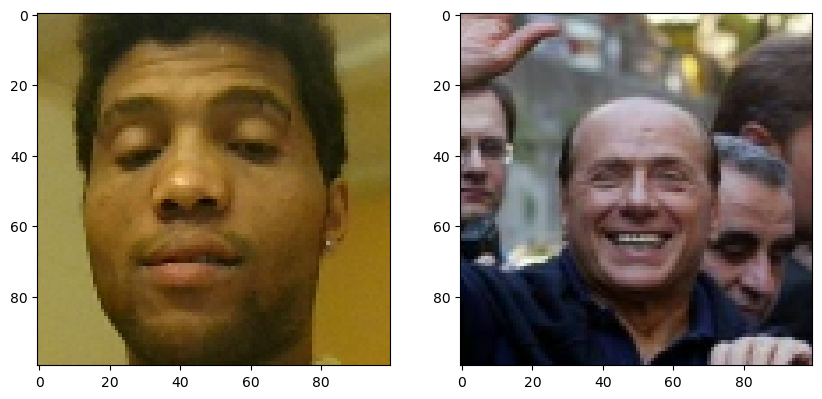

In [47]:
# set plt size
plt.figure(figsize = (10,8))

# set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[0])

# set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[0])
plt.show()

# 07 Save The model

In [49]:
# Save the model
siamese_model.save('siamesemodel.h5')

2024-05-26 10:03:10.790592: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 150994944 exceeds 10% of free system memory.


In [51]:
# Reload the model
model = tf.keras.models.load_model('siamesemodel.h5',
                                 custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy': tf.losses.BinaryCrossentropy})


In [52]:
model.predict([test_input, test_val])

array([[1.6581982e-06],
       [6.9831822e-06],
       [4.8773338e-05],
       [8.2361976e-06],
       [1.8195719e-06],
       [1.3293083e-05],
       [9.8859554e-04],
       [7.3952657e-01],
       [3.7771228e-04],
       [4.1189366e-03],
       [2.0543614e-03],
       [9.9953890e-01],
       [2.5601294e-06],
       [9.9557233e-01],
       [9.9836761e-01],
       [9.3245244e-06]], dtype=float32)

In [53]:
model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
validation_img (InputLayer)     [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
embedding (Functional)          (None, 4096)         38960448    input_img[0][0]                  
                                                                 validation_img[0][0]             
__________________________________________________________________________________________________
l1_dist_2 (L1Dist)              (None, 4096)         0           embedding[0][0]     

# 08 Real Time Test

### 8.1 Verification Function

In [54]:
def verify(frame, model, detection_threshold, verification_threshold):
    # building result array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_image = preprocess(os.path.join('application_data', 'input_image', 'input_images.jpg'))
        validation_image = preprocess(os.path.join('application_data', 'verification_images', image))

        # Make predictions
        result = model.predict(list(np.expand_dims([input_image, validation_image], axis=1)))
        results.append(result)

    # Detection threshold: Metric above which a prediction is considered posetive
    detection = np.sum(np.array(results) > detection_threshold)

    # Verification threshold: proportion of positive predictions/total positive samples
    verification = detection/ len(os.listdir(os.path.join('application_data', 'verification_images')))
    verified= verification > verification_threshold
    return results, verified

    

### 8.2 OpenCV RealTime Verification

In [55]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret,frame = cap.read()

    # Cut-down the frame to 250, 250 pixels size
    frame = frame[100:100+250, 200:200+250, :]
    
    cv2.imshow('Verification', frame)

    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # save input image to application_data/input_image folder
        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_images.jpg'), frame)

        # Run verification
        results, verified = verify(frame, model, 0.5, 0.85)
        print("Is verified: {0} Probability out of 50: {1}".format(verified, np.sum(np.squeeze(results) > 0.85)))
        
        
        
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

[ WARN:0@513.571] global /croot/opencv-suite_1676452025216/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
